In [1]:
figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/figures'

## Import required modules

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ROIenrichment
import _utils

In [3]:
import session_info
session_info.show()

In [8]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200)

## Prepare functions

## Read in anndata

In [5]:
adata_ffpe = _utils.read_visium('/nfs/team205/heart/anndata_objects/8regions/visium-FFPE_adult-8reg_raw.h5ad',lognorm=True)
adata_ffpe

AnnData object with n_obs × n_vars = 11312 × 17725
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc', 'annotation_final', 'Adip1', 'Adip2', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'MoMP', 'NC1_glial', 'NC2

In [6]:
category_name='annotation_final'

## Make the plots smaller by selecting key data

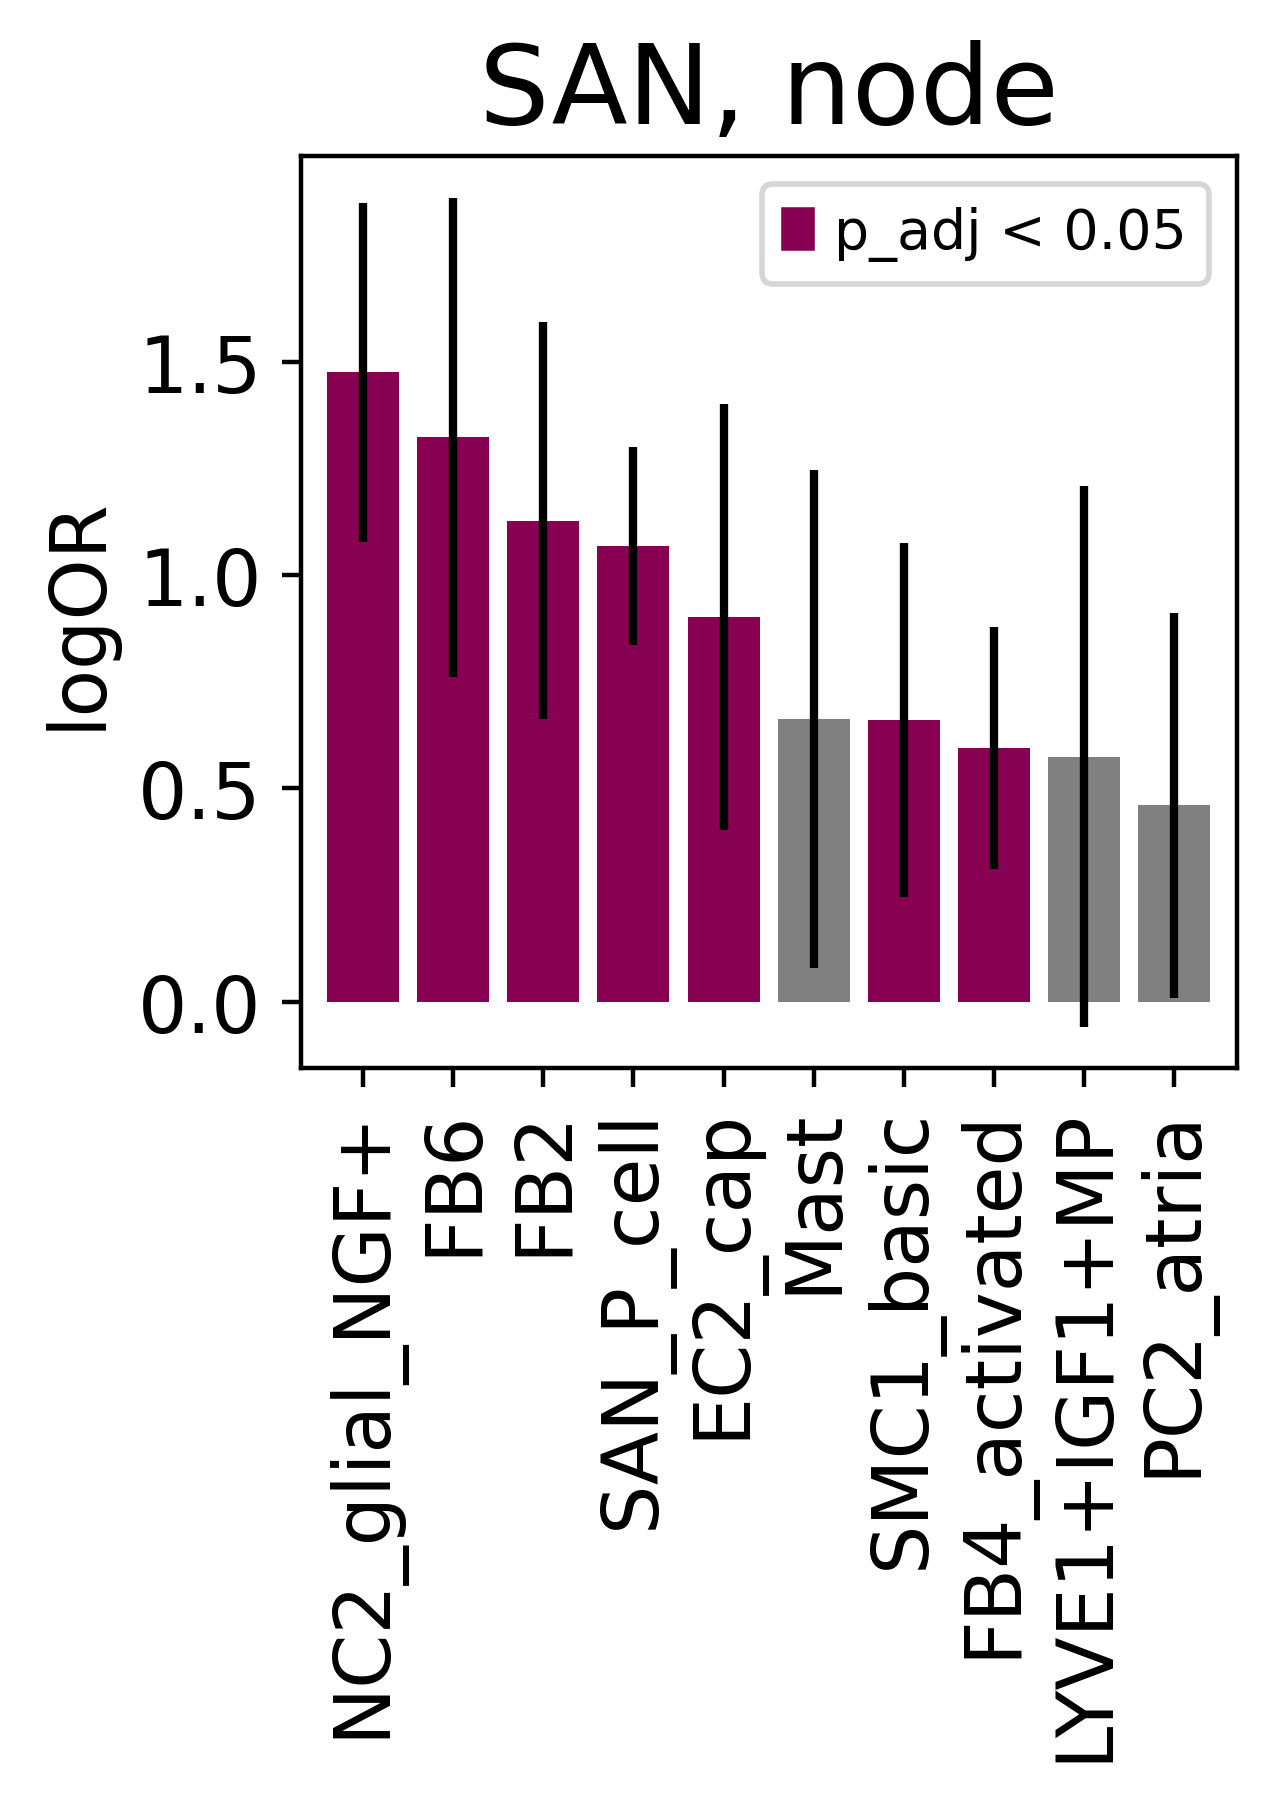

In [25]:
roi='node'
region = 'SAN-FFPE'
filtering = 'rank_pos'  # select from 'rank_pos','pval_pos','rank_both','pval_both'
n_rank = 10
p_adj_thresh = 0.05

slide = adata_ffpe[adata_ffpe.obs['region']==region]

# remove prop-cellstates which doesn't exist in the region (SAN)
rm_list = [x for x in np.sum(slide.obs)[np.sum(slide.obs)==0].index if 'prop_' in x]
slide.obs.drop(rm_list, axis=1, inplace=True)

# ROI enrichment calculation
res=ROIenrichment.ROI_enrichment_allcomparison(slide,roi=roi,category_name=category_name)
res=res.sort_values('logOR',ascending=False)

if filtering=='rank_pos':
    res = res[:n_rank].copy()
elif filtering=='pval_pos':
    res=res[(res['p_adj']<p_adj_thresh)&(res['logOR']>0)]
else:
    if filtering!=None:
        raise KeyError('invalid <filtering>')
    
# plotting
plt.rcParams["figure.dpi"] = 200
# hide grid
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(3,3))
color = ['#870052' if x<p_adj_thresh else 'grey' for x in res['p_adj']]
plt.bar(res['cell'], res['logOR'], yerr=res['ebar'], color=color)
plt.title(f'SAN, {roi}', fontdict={'fontsize':20})
plt.ylabel('logOR')
plt.xticks(rotation= 90)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='#870052')],
           labels=['p_adj < '+str(p_adj_thresh)],
           fontsize=10)

plt.margins(x=0.03)
plt.savefig(f'{figpath}/{region}_{roi}_roienrich.pdf')
plt.show()
